# Problem Set 6: Correcting Bias in Classification
---
This problem set is addapted from the ML Failures lab: Correcting Bias by Nick Merrill, Inderpal Kaur, Samuel Greenberg, which is licensed under [CC BY-NC-SA 4.0](https://creativecommons.org/licenses/by-nc-sa/4.0)

## Feedback

**Students** can [provide feedback here](https://docs.google.com/forms/d/1jI8oXRkqD1l1ARuZR1y9W_qkOystPr-YEyywNDez46M/edit?ts=5efa772a&dods)

# Background

The datasets we use to train machine learning models can often encode human biases. From a social and ethical standpoint, we want to remove or minimize this bias so that our models are not perpetuating harmful stereotypes or injustices. From a business and legal perspective, we want to produce effective models that adhere to industry standards of fairness. 

There are several ways that we can tackle this problem, including pre-processing the data to remove bias before training, in-processing the model to change the way it learns from the data, and post-processing the results to correct for bias. In this assignment, we will be introducing two methods for correcting for bias: a post-processing method that uses alternative classification thresholds for different groups, and an in-processing method to train a logistic regression classifier that maximizes fairness while maintaining a certain level of accuracy. The in-processing method for correcting bias is based on [Fairness Constraints: Mechanisms for Fair Classification](https://arxiv.org/pdf/1507.05259.pdf) by Zafar et al. (2017).


## Agenda

- Introduction
- Part 1: Defining fairness
- Part 2: Observing a classifier's bias in our dataset
- Part 3: Post-processing with alternative thresholds
- Part 4: In-processing with fairness constraints
- Bonus question: Alternative fairness definitions

In [18]:
%%capture
# grabbing the external Python files needed for this lab
# located at https://github.com/daylight-lab/mlfailures/tree/master/lib
!wget https://raw.githubusercontent.com/daylight-lab/mlfailures/master/lib/classify_synthetic_data.py
!wget https://raw.githubusercontent.com/daylight-lab/mlfailures/master/lib/generate_synthetic_data.py

import numpy as np
import pandas as pd
import generate_synthetic_data as generate
import classify_synthetic_data as classify
import matplotlib.pyplot as plt
%matplotlib inline

## Introduction: Gender bias in hiring

Our dataset represents applicants for a job. We want an algorithm to help making hiring decisions, as this process is rife with human bias. However,
studying past data would simply reinforce these biases (as we will see below).

Consider gender in hiring decisions. There is a well-documented [gender pay gap](https://en.wikipedia.org/wiki/Gender_pay_gap): in general, people who identify as women are paid less for the same work than people who identify as men. 

Now, imagine that we want to build a classifier that will make hiring decisions. If we train a classifier to make hiring decisions based on prior work experience and income, we would expect the classifier to *learn* a bias against women. Put another way, we can't make a classifier that is "gender-blind" by simply "throwing out" gender, excluding it from our dataset. Information about gender is already correlated with income.

We do not want our algorithm to learn this bias for gender. **Instead,
we would like our algorithm to *correct* for this bias.**

To discuss this issue more deeply, let's introduce some key terms:

- **Sensitive** features: A feature is *sensitive* when it may contribute to bias. For example, gender is a *sensitive* feature.
- **Protected** classes: A class is *protected* when we expect there is bias against it. For example, being female is a *protected* class in this example.

Let's generate a synthetic dataset that contains the prior income, work experience, and gender of 1,000 applicants who were hired and 1,000 applicants who were not. (For a more detailed explanation of how we generate this toy dataset, see the Appendix below.) 

We represent each individual on the plot below according to their prior income and work experience (the non-sensitive features). The shape of the marker indicates the applicant's gender (the *sensitive* feature). Females, denoted by `x`s, are the *protected* class in this example. The color indicates whether or not they were hired.

<!-- The binary sensitive feature includes a protected group (sensitive feature = 0) and an unprotected group (sensitive feature = 1). **(EXPLAIN WHAT PROTECTED/UNPROTECTED MEANS)** -->


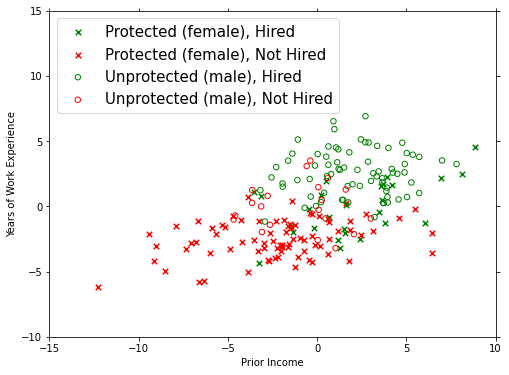

In [19]:
X, y, x_sensitive = generate.generate_synthetic_data(plot_data=True)

The variables here are `X` (non-sensitive feature: years of prior work experience), `y` (label: hired/not-hired), and `x_sensitive` (male/female).

Here, we have effectively created a biased dataset where the sensitive feature *gender* is strongly related to the applicant's hiring status. A female applicant (`x`) seems less likely than a male applicant (`o`) to be hired.
(Again, this is just example data---while gender gap in pay is real, this particular data is synthetic. See the appendix for details.)

## Part 1: Defining Fairness

In order to remove bias from our model, we first need to define bias. 

In this assignment, we will be using **disparate impact** (also known as the **p%-rule**) to measure the unfairness of a data set with respect to a particular sensitive feature. We can measure *how biased* our dataset is by calculating the p%-rule.

### 1.1 Calculate the p% rule

If we take $\mathbf x$ to represent a (non-sensitive) feature vector, $y$ a 1/-1 class label, and $z$ a 0/1 sensitive attribute, the p%-rule states that the ratio between the fraction of subjects assigned the positive decision outcome ($y=1$) given that they have a sensitive attribute value and the fraction of subjects assigned the positive outcome given that they do not have that value should be no less than p%.

In the scenario we described in this lab, the non-sensitive feature vector $\mathbf x$ represents prior income and years of work experience, the class label $y$ represents the hiring status (1 for hired, -1 for not hired), and the sensitive attribute $z$ represents gender (0 for female, 1 for male). The p%-rule would tell us the ratio between the fraction of female applicants who were hired and the fraction of male applicants who were hired.


$$ p = 100\left(\frac{Pr(y=1|z=1)}{Pr(y=1|z=0)}\right) $$




In [20]:
sensitive_features_arr  = np.array(x_sensitive['s1'])

In [21]:
# TODO: Write a function compute_p_rule that takes as inputs a sensitive_features_arr and y (the array of 
# hiring outcomes), and returns the p percent rule. Also have your function print out the number of observations
# in the protected and unprotected class, and the percent of observations in each class that are hired (y=1).

def calculate_p_rule(sensitive_features_arr, y):
    # TODO: Replace 0 in the next line with a calculation of the # of unprotected observations
    #number_unprotected = 0 
    number_unprotected = np.sum(sensitive_features_arr == 1)
    
    # TODO: Replace 0 in the next line with a calculation of the # of protected observations
    #number_protected = 0
    number_protected = np.sum(sensitive_features_arr == 0)
    
    # TODO: Replace 0 in the next line with a calculation of the % of unprotected observations hired
    #percent_pos_unprotected = 0
    percent_pos_unprotected = np.mean(y[np.where(sensitive_features_arr == 1)] > 0)*100
    
    # TODO: Replace 0 in the next line  with a calculation of the % of protected observations hired
    #percent_pos_protected = 0 
    percent_pos_protected = np.mean(y[np.where(sensitive_features_arr == 0)] > 0)*100
    
    # TODO: Replace 0 with a calucalation of the p percent rule, using the previously-defined variables
    #p_percent_rule = 0  
    p_percent_rule = (percent_pos_protected/percent_pos_unprotected)*100
    
    print('Number of protected observations: %i' % number_protected)
    print('Number of unprotected observations: %i' % number_unprotected)
    print('Protected in positive class: %i' % round(percent_pos_protected) + '%')
    print('Unprotected in positive class: %i' % round(percent_pos_unprotected) + '%')
    print('P-rule: %i' % round(p_percent_rule) + '%')
    
    return p_percent_rule

Now test your function using the sensitive_features_arr and hiring outcomes (*y*) from our dataset. Verify that your function is correct: it should output p-percent rule of 29.45%. If you get a different number, go back and correct your code!

In [22]:
calculate_p_rule(sensitive_features_arr, y)

Number of protected observations: 1075
Number of unprotected observations: 925
Protected in positive class: 24%
Unprotected in positive class: 81%
P-rule: 29%


29.45216169814266

**QUESTION A:** Interpret the output of this method to describe the disparate impact between male and female applicants in the training data.

*Answer:* Women are hired only 29% as often as men are hired.

**QUESTION B:** Is there evidence of bias in the training data?

*Answer:* There is evidence of bias in the training data: women are hired at a rate much lower than men, though we know a priori that women and men do not have intrinsicly different ability levels.

## Part 2: Machine learning without correcting for bias.

Now let's turn back to our dataset. Let's see what happens when we *don't* correct for bias and train a machine learning model on our data.

First, we pre-process the data. We add an intercept column and split the data into train and test sets.

In [23]:
intercept = np.ones(X.shape[0]).reshape(X.shape[0], 1)
X = np.concatenate((intercept, X), axis = 1)
pd.DataFrame(X, columns=["intercept", "income", "experience"]).head() # to help us visualize the dataset

,intercept,income,experience
0,1.0,-1.738503,-1.977414
1,1.0,-4.908148,-3.267064
2,1.0,3.006536,-0.925507
3,1.0,0.779730,2.473575
4,1.0,1.193537,-2.595904


In [24]:
# split the data into training and test using a 70/30 split
train_fold_size = 0.7
X_train, y_train, x_sensitive_train, X_test, y_test,  x_sensitive_test =\
    classify.split_into_train_test(X, y, x_sensitive, train_fold_size)

To set our baseline, we'll train a standard logistic regression classifier on our data and see how it performs. (See appendix for more on how this classifier training works).

In [25]:
theta, p_rule, score, distances_from_decision_boundary = classify.train_test_classifier(
    X_train, y_train,  x_sensitive_train, 
    X_test, y_test, x_sensitive_test, 
    ['s1'],  # our list of sensitive features.
    apply_fairness_constraints=0 # We are NOT applying any fairness constraints this time
)  


Accuracy: 0.87
Protected/non-protected in positive class: 86% / 22%
P-rule achieved: 25%
Covariance between sensitive feature and decision from distance boundary : 1.181



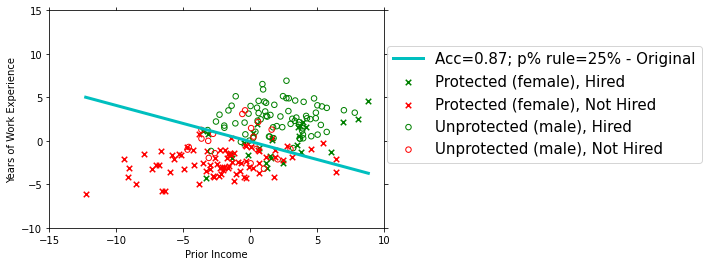

In [26]:
classify.plot_boundaries(X, y, np.array(x_sensitive['s1']), theta, p_rule[0], score)

The blue line represents the decision boundary for our standard logistic regression classifier. The model predicts points above this line as "hired" and points below as "not hired." 

**QUESTION A:** Is our classifier accurate at predicting class labels (as determined by its accuracy rate)?

*Answer:* The classifier is fairly accurate -- a classification accuracy of 87% seems reasonably high.

**QUESTION B:** Is our classifier fair (as determined by its p% rule)? Explain. Hint: female applicants would be labeled "hired" by this classifier at what rate relative to male applicants?

*Answer:* The classifier is not fair. Women are hired only 25% as often as men, even though we know a priori that women and men do not have intrinsicly different ability levels.

**QUESTION C:** How did the classifier learn bias for gender, even though gender was not included?

*Answer:* Because other features in the dataset, such as work experience and prior income, are correlated with with the target variable, the classifier learned to use them to predict whether an observation should be hired or not. However, these features are also correlated with gender: women tend to have less work experience and a lower prior income. These variables therefore encode gender, even though gender itself isn't included as a feature.

# Part 3: Post-processing with alternative thresholds

One option for correcting for this bias is postprocessing model outputs with a method called *thresholding*. This method makes no changes to the classifier itself, but instead processes classifier outputs differently for observations in the protected class and observations in the unprotected class. In the context of this problem set, we can think of thresholds as alternative restrictions on distance from the decision boundary: observations without the sensitive characteristic (males) must be above the decision boundary in order to be hired, but observations with the sensitive characteristic (females) can be up to a distance of *k* below the decision boundary. 

### 3.1 Applying one alternative threshold

First, use the distances_from_decision_boundary obtained earlier from the train_test_classifier function to test out a threshold of 0 for males and a threshold of -1 for females. Identify which observations in the test set will be hired according to these thresholds, and use the compute_p_rule function you wrote earlier to calculate the p% rule. 

In [10]:
sensitive_feature_arr = np.array(x_sensitive_test['s1'])

In [11]:
# TODO: Post-process the outputed distances_from_decision_boundary to apply a threshold of 0 or over for 
# protected observations (sensitive_feature = 1) and a threshold of -1 or over for unprotected observations
# (sensitive_feature = 0). Calculate the p% rule using these post-processed outputs.
unprotected = (distances_from_decision_boundary > 0) & (sensitive_feature_arr == 1)
protected = (distances_from_decision_boundary > -1) & (sensitive_feature_arr == 0)
classifications = np.array([1 if obs else -1 for obs in unprotected + protected])
calculate_p_rule(sensitive_feature_arr, classifications)

Number of protected observations: 335
Number of unprotected observations: 265
Protected in positive class: 30%
Unprotected in positive class: 86%
P-rule: 35%


35.234308805318385

**QUESTION A:** Is this decision method more or less fair than the naive decision method with equal thresholding implemented earlier? Why?

*Answer:* This method is more fair. The p-percent rule is higher: whereas in the naive method women are hired 25% as often as men, with this method women are hired 35% as often as men.

In [ ]:
### 3.2 Varying the threshold

Now let's try out a set of different thresholds. Assume that we will leave the threshold for the unprotected class (males) at 0. Try out a set of thresholds for the protected class (females) between -8 and 0. Try out at least 20 thresholds in this range, and plot the results in a scatterplot, with the threshold on the x-axis and the p% rule on the y-axis. Calculate the threshold at which the p% rule is closest to 100%, and add a vertical line to the scatterplot showing this threshold. Remember to make sure your plot is readable and well-labeled

In [12]:
# TODO: Post-process the outputed distances_from_decision_boundary to apply a threshold of 0 for protected 
# observations and a threshold of k for unprotected observations (sensitive_feature = 0), and calculate the 
# p% rule. Experiment with at least 20 different values of k between -8 and 0.
thresh_grid = np.arange(-8, 0, .2)
p_rules = []
for thresh in thresh_grid:
    unprotected = (distances_from_decision_boundary > 0) & (sensitive_feature_arr == 1)
    protected = (distances_from_decision_boundary > thresh) & (sensitive_feature_arr == 0)
    classifications = np.array([1 if obs else -1 for obs in unprotected + protected])
    p_rules.append(calculate_p_rule(sensitive_feature_arr, classifications))

Number of protected observations: 335
Number of unprotected observations: 265
Protected in positive class: 100%
Unprotected in positive class: 86%
P-rule: 116%
Number of protected observations: 335
Number of unprotected observations: 265
Protected in positive class: 100%
Unprotected in positive class: 86%
P-rule: 116%
Number of protected observations: 335
Number of unprotected observations: 265
Protected in positive class: 100%
Unprotected in positive class: 86%
P-rule: 115%
Number of protected observations: 335
Number of unprotected observations: 265
Protected in positive class: 99%
Unprotected in positive class: 86%
P-rule: 115%
Number of protected observations: 335
Number of unprotected observations: 265
Protected in positive class: 99%
Unprotected in positive class: 86%
P-rule: 115%
Number of protected observations: 335
Number of unprotected observations: 265
Protected in positive class: 99%
Unprotected in positive class: 86%
P-rule: 114%
Number of protected observations: 335
Numbe

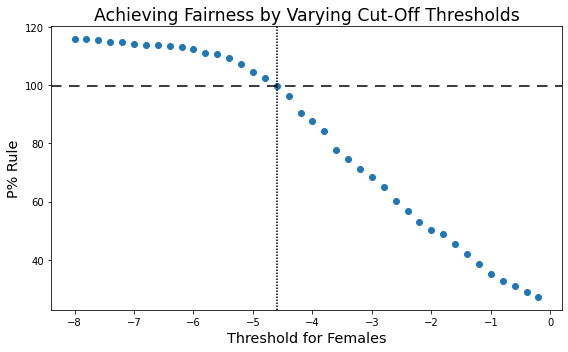

In [13]:
fig, ax = plt.subplots(1, figsize=(8, 5))
ax.scatter(thresh_grid, p_rules)
ax.axhline(p_rules[17], color='black', dashes=[7, 5])
ax.axvline(thresh_grid[17], color='black', dashes=[1, 1])
ax.set_xlabel('Threshold for Females', fontsize='x-large')
ax.set_ylabel('P% Rule', fontsize='x-large')
ax.set_title('Achieving Fairness by Varying Cut-Off Thresholds', fontsize='xx-large')
plt.tight_layout()
plt.show()

# Part 4: In-processing with fairness constraints

An alternative method for correcting for bias is applying fairness constraints in training the machine learning algorithm.

You can see the appendix for more information on how this process works (see Appendix: Applying fairness constraints. But it's best illustrated with an example.

Below, you're going to pick a **hyperparameter gamma**
($\gamma$).
I've set a value of 1.5. See what happens.


Accuracy: 0.41
Protected/non-protected in positive class: 60% / 56%
P-rule achieved: 93%
Covariance between sensitive feature and decision from distance boundary : 0.002



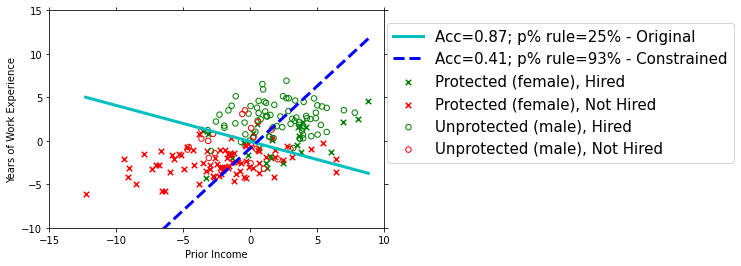

In [14]:
theta1, p_rule1, score1, distances_from_decision_boundary = classify.train_test_classifier(
    X_train, y_train, x_sensitive_train, 
    X_test, y_test, x_sensitive_test, 
    ['s1'],  # our sensitive feature
    apply_accuracy_constraint=1, # applying our fairness constraint.
    gamma=1.5 
    ) 

classify.plot_boundaries(X, y, 
                         sensitive_features_arr,
                         theta, 
                         p_rule[0], 
                         score, 
                         theta1, 
                         p_rule1[0], 
                         score1)

The solid line represents the decision boundary from our naive classifier---the one that scored poorly on the p% rule. That's the same line we saw above.

The *dashed* line represents our new decision boundary: the one from our **constrained** model, to which we applied our gamma hyperparameter.

After applying our bias correction method, the decision boundary *rotates* to produce a more fair distribution of class labels with respect to the sensitive feature. 

At a gamma of 1.5, this method achieves a 93% p-rule, *but* a less accurate classifier.
That's our tradeoff: we're effectively saying the original class labels are biased, and therefore wrong. So we're consciously making this tradeoff.


### 4.1 Fairness-accuracy trade-off

Using this method, we can specify how much we are willing to let the accuracy change by choosing an appropriate $\gamma$ parameter for the model. The larger $\gamma$ is, the more loss we are willing to incur in our corrected model compared to the baseline model. Again, refer to Appendix: Applying fairness constraints to get a better understanding of how this works.

Let's visually explore the *fairness-accuracy trade-off* by varying the value of gamma. Test out at least 20 values of gamma between 0 and 5. For each value, train a constrained model and record the accuracy and p-rule. Then, produce three scatterplots: The first should show gamma on the x-axis and accuracy on the y-axis. The second should show gamma on the x-axis and the p-rule on the y-axis. The third should show the p-rule on the x-axis and accuracy on the y-axis. Remember to make sure the plots are easy to read and well-labeled.


In [30]:
# TODO: experiment with gamma values between 0 and 3. Create plots of gamma vs. p-rule, gamma vs. accuracy, 
# and p-rule vs. accuracy. 
gammas = np.arange(0, 3, .05)
accuracies, p_rules = [], []
for gamma in gammas:
    _, p, a, _ = classify.train_test_classifier(
        X_train, y_train, x_sensitive_train, 
        X_test, y_test, x_sensitive_test, 
        ['s1'],  # our sensitive feature
        apply_accuracy_constraint=1, # NOTE - We are applying our fairness constraint.
        gamma=gamma # TODO - experiment with different hyperparameters!
    ) 
    accuracies.append(a)
    p_rules.append(p)

Accuracy: 0.87
Protected/non-protected in positive class: 86% / 22%
P-rule achieved: 25%
Covariance between sensitive feature and decision from distance boundary : 1.181

Accuracy: 0.87
Protected/non-protected in positive class: 86% / 21%
P-rule achieved: 25%
Covariance between sensitive feature and decision from distance boundary : 0.824

Accuracy: 0.87
Protected/non-protected in positive class: 86% / 21%
P-rule achieved: 25%
Covariance between sensitive feature and decision from distance boundary : 0.702

Accuracy: 0.87
Protected/non-protected in positive class: 86% / 21%
P-rule achieved: 25%
Covariance between sensitive feature and decision from distance boundary : 0.617

Accuracy: 0.87
Protected/non-protected in positive class: 86% / 21%
P-rule achieved: 25%
Covariance between sensitive feature and decision from distance boundary : 0.551

Accuracy: 0.88
Protected/non-protected in positive class: 86% / 21%
P-rule achieved: 25%
Covariance between sensitive feature and decision from d

Accuracy: 0.41
Protected/non-protected in positive class: 56% / 54%
P-rule achieved: 96%
Covariance between sensitive feature and decision from distance boundary : 0.003

Accuracy: 0.41
Protected/non-protected in positive class: 56% / 54%
P-rule achieved: 96%
Covariance between sensitive feature and decision from distance boundary : 0.003

Accuracy: 0.41
Protected/non-protected in positive class: 56% / 54%
P-rule achieved: 96%
Covariance between sensitive feature and decision from distance boundary : 0.003

Accuracy: 0.41
Protected/non-protected in positive class: 56% / 54%
P-rule achieved: 96%
Covariance between sensitive feature and decision from distance boundary : 0.003

Accuracy: 0.41
Protected/non-protected in positive class: 56% / 54%
P-rule achieved: 96%
Covariance between sensitive feature and decision from distance boundary : 0.003

Accuracy: 0.41
Protected/non-protected in positive class: 56% / 54%
P-rule achieved: 96%
Covariance between sensitive feature and decision from d

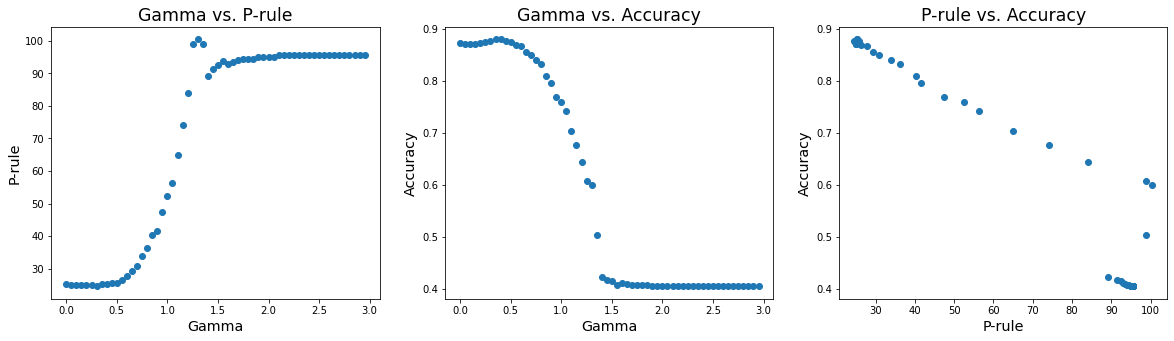

In [31]:
fig, ax = plt.subplots(1, 3, figsize=(20, 5))
ax[0].scatter(gammas, p_rules)
ax[0].set_title('Gamma vs. P-rule', fontsize='xx-large')
ax[0].set_xlabel('Gamma', fontsize='x-large')
ax[0].set_ylabel('P-rule', fontsize='x-large')
ax[1].set_title('Gamma vs. Accuracy', fontsize='xx-large')
ax[1].set_xlabel('Gamma', fontsize='x-large')
ax[1].set_ylabel('Accuracy', fontsize='x-large')
ax[2].set_title('P-rule vs. Accuracy', fontsize='xx-large')
ax[2].set_xlabel('P-rule', fontsize='x-large')
ax[2].set_ylabel('Accuracy', fontsize='x-large')
ax[1].scatter(gammas, accuracies)
ax[2].scatter(p_rules, accuracies)
plt.show()

The following questions have no right answer. Instead, they are meant to make you think about the nuances of navigating correcting for bias in practice. 

**QUESTION A**: What is the "right" value for $\gamma$? Why? Can you think of an empirical way to justify your choice for the "right" gamma value? 

In [52]:
# Balancing accuracy and p-rule by getting closest to the top-right corner of the third plot
distances = []
for a, p in zip(accuracies, [pr[0]/100 for pr in p_rules]):
    distances.append(np.linalg.norm(np.array([1, 1]) - np.array([a, p])))
print('One option for best gamma: %.2f' % gammas[np.argmin(distances)])

One option for best gamma: 1.20


*Answer:* One option for the "right" $\gamma$ value is one that achieves a p-rule-of 100%. In that case, a $\gamma$ value of 1.3 will be chosen. This choice represents valuing fairness above accuracy: we are willing to settle for fairly low accuracy (around 60%) in return for perfect fairness. Another option for the "right" $\gamma$ value is the one that achieves accuracy of 100%. In that case, a $\gamma$ value of 0.35 will be chosen. This choice represents valuing accuracy above fairness: we are willing to impose little to no fairness constraint in order to maximize classifier accuracy. A third option is to choose the point closest to the top-right corner of the third plot in question 4.1, this represents equally balancing the objects of accuracy and p-rule. In this case the optimal $\gamma$ would be 1.20. Yet a fourth option is a weighted balancing of the two objectives by adding weights to the mean squared error calculation from the third option. Weights could be assigned to the fairness or accuracy objective so that one matters more than the other. [*Note: Any answer will be accepted so long as it (1) provides a specific empirical value for gamma and (2) a well-reasoned explaination*]. 

**QUESTION B**: What kinds of discussions or decision making processes could help us agree on $\gamma$? 


*Answer:* The key to agreeing on $\gamma$ will be agreeing on how much to weight the objectives of fairness and accuracy in this application. In some fields, there are legal definitions around what kinds of fairness constraints need to be set -- in that case, looking at precedents from the courts in similar applications may be helpful. In other cases, it will come down to the preferences of stakeholders in the hiring pipeline --- see question C below. [*Note: Any well-reasoned answer will be given full credit.*]

**QUESTION C**: In the case of hiring, whom should these discussions involve? How about other cases? Remember that different stakeholders have different levels of understanding about machine learning, and different levels of understanding about social issues such as gender and racial bias.

*Answer:* The discussions should involve stakeholders across the hiring pipeline in this case. These include executive and HR managers at the companies using the algorithm, the designers of the algorithm itself, current employees of companies using the algorithm, and perhaps most importantly job applicants who may be sorted by the algorithm. Other cases will have other sets of stakeholders, but the key here is to involve stakeholders from across the spectrum of involvement with the algorithm (whether involvement means designing the algorithm or being impacted by it). The tricky part is that, as noted in the question, different stakeholders will have different degrees of understanding of the algorithm itself and of the fairness issues at stake, so a key part of the discussions will be getting everyone as comfortable as possible with the machine learning and social challenges at stake, and trying to ensure that vulnerable groups are placed in a powerful position in the discussions and negotiations. [*Note: Any well-reasoned answer that mentions involving stakeholders, especially those who will be sorted by the algorithm, will recieve full credit.*]

**QUESTION D**: Is there some point at which we should stop trying to correct for bias in our data? If so, how do we determine that point?

*Answer:* As in the answer to part B above, the point at which we should stop correcting for bias in the training data depends on our preferences over the fairness and accuracy objectives for this classifier. If our preferences are entirely for fairness, we will not stop correcting for bias until the training data is truely representative of the underlying population. If our preference is entirely for accuracy, we may not need to correct bias at all.  [*Note: Any well-reasoned answer will be given full credit.*]

## Bonus Question: Alternative Ways of Defining Fairness  

In this assignment, we have used disparate impact -- as quantified by the p% rule -- to measure bias in our dataset and predictions. However, disparate impact is not the only way to quantify fairness. For this question, we'll look at another option for defining fairness: *disparate mistreatment*, introduced by [Zafar et al. (2017b)](https://dl.acm.org/doi/10.1145/3038912.3052660).  Disparate mistreatment focuses on the misclassification rates between groups -- that is, it compares the *true positive rate* for the protected class to the *true positive rate* for the unprotected class. In the context of our dataset, disparate mistreatment compares the rate at which qualified females are hired in comaprison to the rate at which qualified men are hired. 

Let $\hat{y}$ be the prediction of the classifier for an observation. Then disparate mistreatment is defined as: 

$$ m = 100 \left( \frac{Pr(\hat{y}=1 | y=1, z=1)}{Pr(\hat{y}=1 | y=1, z=0)} \right) $$

Write a function calculate_disparate_mistreatment that takes in a sensitive_features_arr and *y* (the true hiring labels), along with *distances_from_decision_boundary* as outputed by the *train_test_classifier* method, and returns *m*, the measure of disparate mistreatment. Also have your function print out the true positive rate for each of the classes.

In [17]:
# Code up disparate mistreatment
def calculate_disparate_mistreatment(sensitive_features_arr, y, distances_from_decision_boundary):
    
    # TODO: Replace 0 with the true positive rate in the unprotected class
    #tpr_unprotected = 0
    yhat = np.sign(distances_from_decision_boundary)
    tpr_unprotected = 100*np.mean(yhat[np.where((sensitive_features_arr == 1) & (y == 1))] > 0)
    
    # TODO: Replace 0 with the the true positive rate in the protected class
    #tpr_protected = 0
    tpr_protected = 100*np.mean(yhat[np.where((sensitive_features_arr == 0) & (y == 1))] > 0)
    
    # TODO: Replace 0 with your calculation of disparate mistreatment
    #disparate_mistreatment = 0
    disparate_mistreatment = 100*(tpr_protected/tpr_unprotected)
    
    print('True positive rate for unprotected class: %i' % tpr_unprotected + '%')
    print('True positive rate for protected class: %i' % tpr_protected + '%')
    print('Disparate mistreatment: %i' % disparate_mistreatment + '%')
    
    return disparate_mistreatment


In [18]:
# Unconstrained classifier
theta, p_rule, score, distances_from_decision_boundary = classify.train_test_classifier(
    X_train, y_train,  x_sensitive_train, 
    X_test, y_test, x_sensitive_test, 
    ['s1'],  # our list of sensitive features.
    apply_fairness_constraints=0 # We are NOT applying any fairness constraints this time
)  

Accuracy: 0.87
Protected/non-protected in positive class: 86% / 22%
P-rule achieved: 25%
Covariance between sensitive feature and decision from distance boundary : 1.181



In [19]:
# Test disparate mistreatment on the predictions of the unconstrained classifier
sensitive_features_arr = np.array(x_sensitive_test['s1'])
calculate_disparate_mistreatment(sensitive_features_arr, y_test, distances_from_decision_boundary)

True positive rate for unprotected class: 97%
True positive rate for protected class: 63%
Disparate mistreatment: 65%


65.58369167064818

In [20]:
# Constrained classifier
theta1, p_rule1, score1, distances_from_decision_boundary = classify.train_test_classifier(
    X_train, y_train, x_sensitive_train, 
    X_test, y_test, x_sensitive_test, 
    ['s1'],  # our sensitive feature
    apply_accuracy_constraint=1, # applying our fairness constraint.
    gamma=1.5 
) 

Accuracy: 0.41
Protected/non-protected in positive class: 60% / 56%
P-rule achieved: 93%
Covariance between sensitive feature and decision from distance boundary : 0.002



In [21]:
# Test disparate mistreatment on the predictions of the constrained classifier
sensitive_features_arr = np.array(x_sensitive_test['s1'])
calculate_disparate_mistreatment(sensitive_features_arr, y_test, distances_from_decision_boundary)

True positive rate for unprotected class: 58%
True positive rate for protected class: 26%
Disparate mistreatment: 44%


44.940659340659344

**QUESTION A**: Did using a classifier that was constrained to reduce disparate impact improve disparate mistreatment?

*Answer:* No, using the constrained classifier in fact increased disparate impact. 

**QUESTION B**: In general, what is the relationship between disparate impact and disparate mistreatment? Why? *Hint*: A useful resource for this question is [Barocas et al. (2019)](https://fairmlbook.org), Chapter 2. Barocas et al. use different terms for the fairness metrics we study here: disparate impact is referred to as *independence* and disparate mistreatment is referred to as *separation*. 

*Answer:* In general, decreasing disparate impact will actually increase disparate mistreatment, as we saw in the empirical example above. Barocas et al. prove that when the sensitive attribute and the prediction are not independent (which, in this problem, they are not), acheiving a p-rule of 100% and an m-rule of 100% at the same time is impossible.

**QUESTION C:** Tell a story where reducing disparate impact may unintentially increase disparate mistreatment. This story can be in the context of this problem set, but it doesn't have to be.

*Answer:* In the context of this problem, we might consider changing the decision boundary to weight prior experience more than income. This will result in hiring more women rather than men (that is, more women will be predicted positive) -- but most of these women will be false positives according to the true label, so the true positive rate for women won't be greatly increased. On the other hand, women who have a high income will now no longer be hired, and this is where most of the true positive for women live -- so the true positive rate for women will go down. As such, disparate impact will be reduced but disparate mistreatment will be increased. [*Note: Any well-reasoned answer that correctly illustrated the definitions of disparate impact and disparate mistreatment, and correctly identifies the relationship between disparate impact and disparate mistreatment, will be given full credit.*]

**QUESTION D**: How might we decide which fairness metric is employed to test for bias in a classifier? Alternatively, how might we balance multiple fairness criteria? What kinds of decision mamking processes or tools could be employed, and who should be involved in these discussions?

*Answer:* Which fairness metric is used depends on the application at hand the goals for the fairness adjustment. In some applications, there are legal requirements for fairnesss, which may specify which fairness metric is used. In other situations, where there is no agreed upon metric for the problem at hand, a meeting of stakeholders as described in Question 3 part C will be required. [*Note: Any well-reasoned answer will be given full credit.*]

# Conclusion

Even if we exclude sensitive attributes from our training procedure, models trained on biased data with strong correlations between sensitive and non-sensitive attributes can still replicate or even emphasize that bias in their predictions. 

We can correct for that bias, but doing so will *always* incur tradeoffs in accuracy. In a way, our bias correction is a claim that the data are "misclassified" in the first place. In this lab's example, we think there are too few women labeled as "hired." So we're finding a compromise between correcting that bias and fitting the data we already have.

Based on a paper by Zafar et. al, we demonstrated a bias correction method we can control by setting the hyperparameter $\gamma$. 
But remember: different industries often have different standards for how fair is "fair enough" or how accurate is "accurate enough" for a model to be considered acceptable for use. 

## Appendix


### Generating the toy dataset
To generate the non-sensitive features, we assign each class a bivariate Gaussian distribution and draw the 2 non-sensitive features for each data point from the appropriate distribution. To generate a biased sensitive feature correlated with the non-sensitive features, we rotate the non-sensitive features; the closer the rotation angle is to 0, the more correlated our sensitive feature will be to the non-sensitive features. We use these rotated coordinates to generate a Bernoulli distribution from which to draw the binary sensitive feature. We set the parameters of this distribution such that an individual in the dataset is more likely to be in the unprotected sensitive group (sensitive feature = 1) if the rotated non-sensitive features are also more likely to belong to the positive class (class label = 1).

### Applying fairness constraints

To do so, we first define the _decision boundary covariance_ as a measure of the covariance between the sensitive feature $\mathbf{z}$ and the classifier's decision $d_{\boldsymbol{\theta}}(\mathbf{x})$. For a logistic regression classifier, the classifier's decision is based on the dot product of the parameters $\boldsymbol{\theta}$ that the model learns and the feature values $\mathbf x$.

$$ Cov(\mathbf{z}, d_{\boldsymbol{\theta}}(\mathbf{x})) = \frac{1}{N} \sum_{i=1}^{N} (\mathbf{z}_i-\bar{\mathbf{z}}) \boldsymbol{\theta}^T  \mathbf x_i$$

Now, the whole idea here is that
we *don't* want the sensitive feature to influence our classifier's decision.
Put another way,
we want to demonstrate that the sensitive feature and the classifier's decision boundary don't covary---or, at least that the decision boundary covariance is close to 0. Now, we could adjust the classifier to minimize the decision boundary covariance, but this might lead to a significant loss in accuracy which could make our model unusable in practice. 

Instead, we want to make our decisions as fairly as possible, with some limit on how low the accuracy can be to produce a functional classifier. So we can set up a mathematical way to frame the trade-off between accuracy and fairness: 
we can minimize the decision boundary covariance (maximize fairness) given some upper bound on the model's loss (an accuracy constraint).

If $Loss(\boldsymbol{\theta}^*)$ represents the loss of our baseline classifier without any bias correction, we can set the parameter $\gamma$ to specify how much additional loss we are willing to add to the baseline loss. 
So our bias correction method can be written:

$$ \text{find}\ \boldsymbol{\theta}\ \text{that minimizes} \ \ \ \big \lvert Cov(\mathbf{z}, d_{\boldsymbol{\theta}}(\mathbf{x})) \big\rvert $$

$$ \text{subject to} \ \ \ Loss(\boldsymbol{\theta}) \le (1+\gamma)Loss(\boldsymbol{\theta}^*)$$

We refer to this constraint as the hyperparameter gamma ($\gamma$).